Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [11]:
from random import choices

import lab9_lib

In [12]:
fitness = lab9_lib.make_problem(2)
for n in range(2):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

01101100000000000111110011001010011000001100001110: 20.20%
11001001101111100111101101100100100110001010110011: 29.60%
2


### Genetic Algorithm
With some more tricks

In [13]:
from copy import deepcopy
from matplotlib import pyplot as plt
from tqdm import tqdm
from typing import Self

import numpy as np
import random

import lab9_lib

Configuration parameters

In [14]:
POPULATION_SIZE = 100
OFFSPRING_SIZE = 500
TOURNAMENT_SIZE = 2
MUTATION_PROBABILITY = 0.2
FITNESS_HOLE_PROBABILITY = 0.1
RANDOM_RESTART_PROBABILITY = 0.1
PROPORTIONAL_MUTATION_PROBABILITY = 0.3
OFFSPRING_ENTROPY_CUT = 0
NUM_LOCI = 1000
PROBLEM_INSTANCE = 2
EPOCHS = 600
CROSSOVER_KIND = "uniform"

Individual class definition

In [15]:
class Individual:
    def __init__(self, genome: list, fitness_function: lab9_lib.AbstractProblem):
        self._genome: list = genome
        self._fitness: float = None
        self._fitness_function = fitness_function

    def eval_fitness(self) -> None:
        self._fitness = self._fitness_function(self._genome)
    
    # Function to compare two individual, used as fitness hole in parent selection
    def comp(self, other: Self):
        return sum(other.get_genome()) - sum(self._genome)

    def get_genome(self) -> list:
        return self._genome

    def get_fitness_value(self) -> float:
        return self._fitness

    def __str__(self):
        return f"{''.join(str(g) for g in self._genome)}: {self._fitness:.2%}"

Shannon entropy function definition 

In [16]:
def calculate_entropy(individual: Individual):
    # Calculate the frequency of each unique value in the feature
    _, counts = np.unique(individual.get_genome(), return_counts=True)

    # Calculate the probabilities of each unique value
    probabilities = counts / NUM_LOCI

    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    return entropy

Genetic Algorithm methods

In [17]:
def create_population(fitness_function: lab9_lib.AbstractProblem) -> list[Individual]:
    population = []
    for _ in range(POPULATION_SIZE):
        individual_genome = random.choices([0, 1], k=NUM_LOCI)
        population.append(Individual(individual_genome, fitness_function))
    return population


def parent_selection(population: list[Individual]) -> Individual:
    chosen_parents: list[Individual] = [random.choice(population) for _ in range(TOURNAMENT_SIZE)]

    best_parent = None
    best_parent_fitness = None

    if random.random() < FITNESS_HOLE_PROBABILITY:
        # Fitness hole
        if chosen_parents[0].comp(chosen_parents[1]) < 0:
            best_parent = chosen_parents[0]
        else:
            best_parent = chosen_parents[1]
    else:
        # Classical fitness-based selection
        for parent in chosen_parents:
            if parent.get_fitness_value() is None:
                parent.eval_fitness()
            cur_parent_fitness = parent.get_fitness_value()

            if best_parent_fitness is None or cur_parent_fitness < best_parent_fitness:
                best_parent_fitness = cur_parent_fitness
                best_parent = parent

    return best_parent


def mutate(individual: Individual, fitness_function: lab9_lib.AbstractProblem, mut_fact: float) -> Individual:
    new_genome = deepcopy(individual.get_genome())
    
    # Randomly select if the mutation is a standard one or a proportional one
    if random.random() < PROPORTIONAL_MUTATION_PROBABILITY:
        # Change a number of loci proportional to a given mutation factor
        num_loci = max(int(mut_fact * NUM_LOCI), 1)
        idxs_to_be_changed = random.choices(range(0, NUM_LOCI - 1), k=num_loci)
        for i in idxs_to_be_changed:
            new_genome[i] = 1 - new_genome[i]
    else:
        # Change one single locus
        idx_to_be_changed = random.randint(0, NUM_LOCI - 1)
        new_genome[idx_to_be_changed] = 1 - new_genome[idx_to_be_changed]

    return Individual(new_genome, fitness_function)


def crossover(individual1: Individual, individual2: Individual,
              fitness_function: lab9_lib.AbstractProblem) -> Individual:
    genome1 = individual1.get_genome()
    genome2 = individual2.get_genome()

    new_individual_genome = []
    if CROSSOVER_KIND == "uniform":
        # Uniform crossover
        for i in range(NUM_LOCI):
            new_individual_genome.append(random.choice([genome1[i], genome2[i]]))
    elif CROSSOVER_KIND == "one-cut":
        # One-cut crossover
        cut = random.randint(0, NUM_LOCI - 1)
        new_individual_genome = genome1[:cut] + genome2[cut:]
    elif CROSSOVER_KIND == "two-cut":
        # Two-cut crossover
        cut1 = random.randint(0, NUM_LOCI - 2)
        cut2 = random.randint(cut1, NUM_LOCI - 1)
        new_individual_genome = genome1[:cut1] + genome2[cut1:cut2] + genome1[cut2:]

    return Individual(new_individual_genome, fitness_function)

Genetic algorithm logics 

In [18]:
def genetic_algorithm(population: list[Individual], fitness_function: lab9_lib.AbstractProblem, avg_fit: list) -> list[Individual]:
    offspring = []
    
    # Randomly create a new offspring composed entirely by random individuals
    if random.random() < RANDOM_RESTART_PROBABILITY:
        for _ in range(OFFSPRING_SIZE):
            individual_genome = random.choices([0, 1], k=NUM_LOCI)
            o = Individual(individual_genome, fitness_function)
            o.eval_fitness()
            offspring.append(o)
    else:
        for counter in range(OFFSPRING_SIZE):
            if random.random() < MUTATION_PROBABILITY:
                # calculate a mutation factor inversely proportional to the fitness improvement of the last 20 epochs
                mut_fact = 0.35 - (avg_fit[-1] - avg_fit[max(-20, -len(avg_fit))])
                a = parent_selection(population)
                o = mutate(a, fitness_function, mut_fact)
            else:
                # crossover
                a1 = parent_selection(population)
                a2 = parent_selection(population)
                o = crossover(a1, a2, fitness_function)
            o.eval_fitness()
            offspring.append(o)
    
    # If set, introduce an entropy-based offspring cut before survival selection
    if OFFSPRING_ENTROPY_CUT > 0:
        # Take those who increment most the entropy
        entropy_offspring = []
        for element in offspring:
            entropy_offspring.append(calculate_entropy(element))

        idxs = np.argsort(entropy_offspring).tolist()
        reduced_offspring_idxs = idxs[:OFFSPRING_ENTROPY_CUT]
        reduced_offspring = [offspring[i] for i in reduced_offspring_idxs]
        offspring = reduced_offspring

    population.extend(offspring)

    # Simulated annealing survival selection
    improvement = (avg_fit[-1] - avg_fit[max(-10, -len(avg_fit))])
    if improvement < 0.001:
        # Simulated annealing survival selection
        population.sort(key=lambda individual: individual.get_fitness_value(), reverse=True)
        taken = (random.choices(population, weights=[i.get_fitness_value() for i in population], k=int(POPULATION_SIZE * 0.2))
                 + population[:int(POPULATION_SIZE * 0.8)])
    else:
        # Classical Survival selection
        population.sort(key=lambda individual: individual.get_fitness_value(), reverse=True)
        taken = population[:POPULATION_SIZE]

    return taken

Main

100%|██████████| 600/600 [01:17<00:00,  7.74it/s]


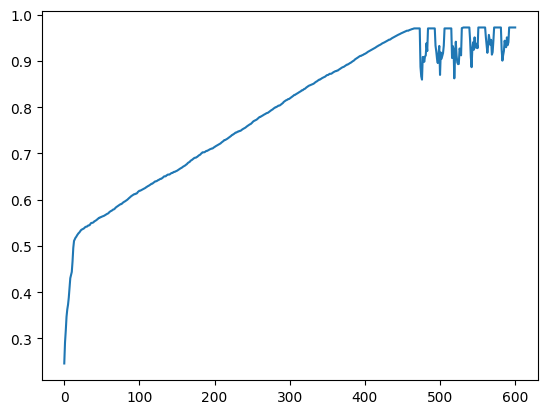

300100
111111111111111111111110111110111111111111111111111110111110111111111111111111111111111111111111111111111111111110111111111111111111101111111111111111111111111111111101111111111111111111111111111111111111111111011111111111111111111111111111111111011111111111111111111111111111111101111111111111111111111111111111111111111110111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111011111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111101111111111111111111111111101111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111101011101111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111011011110111111111111111111111111111111111111111111011111111111111111111111111

In [19]:
fitness = lab9_lib.make_problem(PROBLEM_INSTANCE)

current_population = create_population(fitness)
for ind in current_population:
    ind.eval_fitness()

avg_fitness_values = [np.average([individual.get_fitness_value() for individual in current_population])]
epochs_done = 1
for _ in tqdm(range(EPOCHS)):
    # print(f"Running epoch {_}")
    new_population = genetic_algorithm(current_population, fitness, avg_fitness_values)
    avg_fitness = np.average([individual.get_fitness_value() for individual in new_population])
    # print(f"\tAverage fitness: {avg_fitness}")
    avg_fitness_values.append(avg_fitness)
    current_population = new_population
    epochs_done += 1

    if avg_fitness == 1:
        break

# Plot average fitness trend
plt.plot(range(epochs_done), avg_fitness_values)
plt.show()

print(fitness.calls)
for ind in current_population:
    print(ind)